In [1]:
import sys 
BASE_DIR="/home/asirvent/second_CTA_analysis"
sys.path.append(f"{BASE_DIR}/src/CTA-data-analisis-library/")
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns
import os 
import re 
import glob 
import tensorflow as tf 
import seaborn as sns
import pandas as pd
import gc
import pickle 
import ast
from sklearn.metrics import confusion_matrix

from matplotlib.lines import Line2D

#propias
import unzipdata_and_first_treatments as manipulate
import loaddata4use
import model_creation_functions as models
import model_results_representations
# %%
PATH_TXT=f"/home/asirvent/SimTelArray_2022_05"

RESULTS_DIR=f"/home/asirvent/second_CTA_analysis/notebooks/results_UGR/energias"


2023-07-09 19:17:33.270674: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE3 SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
/usr/lib/python3.11/site-packages/h5py/__init__.py:36: UserWarning: h5py is running against HDF5 1.14.1 when it was built against 1.14.0, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [2]:
# %%
# voy a cargar toda la info de los txt para cada elemento 
elementos=['gamma', 'electron']
aux2=[]
for i , elemento in enumerate(elementos):
    #dict_master[elemento]={}
    list_aux=glob.glob(f"{PATH_TXT}/extract_{elemento}/*.txt")
    list_aux=sorted(list_aux)

    for dir_aux in list_aux:
        run_aux=int(re.findall("(\d{3})\.txt",dir_aux)[0])
        tel_aux=int(re.findall("tel_(\d{1})_run",dir_aux)[0])
        #La idea es tener un diccionario enorme de todo lo que podemos necesitar para seleccionar el rango de todo y las distribuciones.  
        # Esto lo logramos con los datos de extract  
        array_aux=loaddata4use.extract_info_txt(dir_aux)
        if array_aux.size>0:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":array_aux[:,2],"eventos":array_aux[:,0].astype(int)})
        else:
            aux2.append({"elemento":elemento,"run":run_aux,"tel":tel_aux,"energia":np.nan,"eventos":np.nan})
df_final=pd.DataFrame.from_dict(aux2)
df_final

,elemento,run,tel,energia,eventos
0,gamma,1,1,"[0.1087, 0.0616, 0.0904, 4.5563, 0.3297, 0.057...","[800, 1200, 1700, 2300, 3600, 4200, 4300, 5200..."
1,gamma,2,1,"[0.0957, 0.0321, 0.2691, 0.0559, 0.2708, 1.74,...","[100, 400, 700, 2100, 2500, 3100, 3300, 3500, ..."
2,gamma,3,1,NaN,NaN
3,gamma,4,1,"[0.0424, 0.1245, 0.0328, 0.0341, 1.0774, 0.070...","[100, 200, 700, 1800, 2200, 2600, 3500, 3900, ..."
4,gamma,5,1,"[0.2236, 0.2041, 0.0704, 0.1473, 0.0458, 0.095...","[200, 600, 800, 1000, 1700, 1900, 3500, 3600, ..."
...,...,...,...,...,...
1852,electron,366,4,"[3.8508, 2.5637, 2.1473, 3.1065, 4.4443, 1.969...","[3600, 3900, 4200, 6800, 10000, 10400, 10800, ..."
1853,electron,367,4,"[1.1416, 2.414, 2.2999, 2.6604, 1.9844, 2.4216...","[700, 2200, 4300, 5400, 7500, 8300, 8500, 8700..."
1854,electron,368,4,"[2.4048, 2.6701, 1.1435, 4.9955, 1.5433, 2.002...","[500, 700, 1900, 2100, 4100, 4700, 11200, 1330..."
1855,electron,369,4,"[3.813, 3.5752, 2.6346, 1.6029, 4.898, 4.9678,...","[1700, 2400, 3000, 5300, 8000, 11300, 15200, 1..."


In [3]:

# %%
def f_get_comon_events(df):
    all_eventos=np.concatenate(df["eventos"].to_numpy())
    event,count=np.unique(all_eventos,return_counts=True)
    all_energias=np.concatenate(df["energia"].to_numpy())
    energias_eventos_comunes=[]
    for i in event[count==4]:
        indx=np.argwhere(i==all_eventos)
        if np.unique(all_energias[indx]).size!=1:
            print("Algo ha pasado con el evento i, no coinciden las energias")
        energias_eventos_comunes.append(all_energias[indx[0]][0])
    return pd.DataFrame({"eventos":event[count==4],"energia":energias_eventos_comunes})

# %%
df_common_events=df_final.dropna().groupby(["elemento","run"]).apply(f_get_comon_events).droplevel(2).reset_index()#.to_frame()
df_common_events


,elemento,run,eventos,energia
0,electron,1,55300,0.1307
1,electron,1,74000,0.1603
2,electron,1,82500,0.8038
3,electron,1,109700,0.6685
4,electron,1,152100,0.2394
...,...,...,...,...
203816,gamma,100,399300,2.9007
203817,gamma,100,399400,3.4785
203818,gamma,100,399700,2.9609
203819,gamma,100,399900,4.0264


In [4]:
df_lista_runs=pd.read_csv(f"{RESULTS_DIR}/runs_train_test_energy_2.csv",index_col=[0])
df_lista_runs.loc["list_runs"]=df_lista_runs["list_runs"].apply(ast.literal_eval)

df_lista_runs=df_lista_runs.iloc[:-1] # se crea una fila que no se de donde sale.

In [5]:
# %%
# voy a cargar toda la info de los txt para cada elemento 
elementos=['gamma', 'electron']


#df_lista_runs.to_csv(f"{RESULTS_DIR}/runs_train_test_energy_2.csv")
df_lista_runs["list_runs"]=df_lista_runs["list_runs"].apply(lambda x : ast.literal_eval(x))
# %%
train_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Train"].set_index("elemento")
train_runs=train_runs.loc[elementos].reset_index()
train_runs_list=list(train_runs["list_runs"].to_numpy())


# %%
test_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Test"].set_index("elemento")
test_runs=test_runs.loc[elementos].reset_index()
test_runs_list=list(test_runs["list_runs"].to_numpy())

# %%
PATH_npy=f"{BASE_DIR}/data_full/elementos_npy"
# %%
aux_list=[i[-300:] for i in train_runs_list]

In [6]:
#sacar el número de enventos usados para el entrenamiento

#numero de runs usadas para el entrenamiento
print([len(i)for i in train_runs_list])
print([len(i)for i in test_runs_list])

#numero de eventos disponibles en esas runs 


#electron train
print(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in train_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]].shape[0])

#gmma train
print(df_common_events.loc[(df_common_events["elemento"]=="gamma")].loc[[True if i in train_runs_list[0] else False for i in df_common_events.loc[df_common_events["elemento"]=="gamma","run"]]].shape[0])

#electron test
print(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in test_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]].shape[0])

#gamma test
print(df_common_events.loc[(df_common_events["elemento"]=="gamma")].loc[[True if i in test_runs_list[0] else False for i in df_common_events.loc[df_common_events["elemento"]=="gamma","run"]]].shape[0])

[75, 276]
[20, 70]
69096
93461
17520
23744


In [10]:
df_common_events=df_common_events.rename(columns={"energia":"energy (TeV)"})

In [11]:
df_common_events

,elemento,run,eventos,energy (TeV)
0,electron,1,55300,0.1307
1,electron,1,74000,0.1603
2,electron,1,82500,0.8038
3,electron,1,109700,0.6685
4,electron,1,152100,0.2394
...,...,...,...,...
203816,gamma,100,399300,2.9007
203817,gamma,100,399400,3.4785
203818,gamma,100,399700,2.9609
203819,gamma,100,399900,4.0264


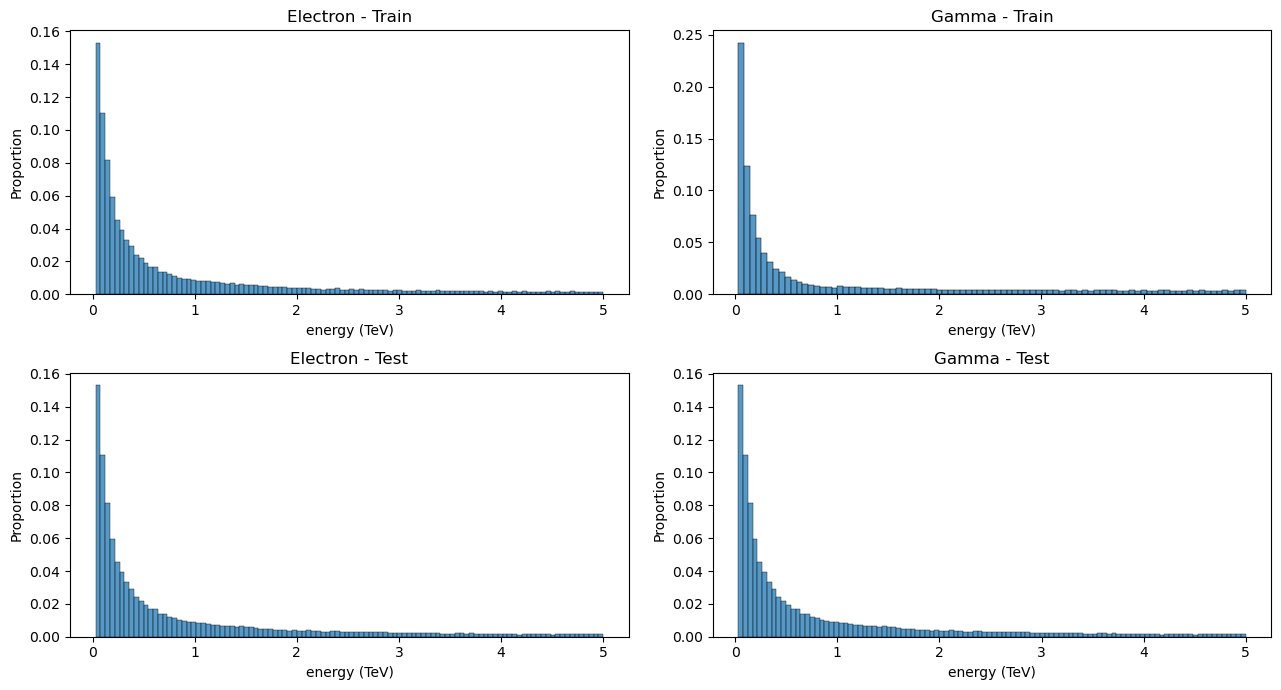

In [12]:
# un poco de info sobre las PDF de la energy (TeV) en estos eventos
plt.figure(figsize=(13,7))
ax=plt.subplot(2,2,1)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in train_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]],x="energy (TeV)",ax=ax,stat="proportion")
plt.title("Electron - Train")

ax=plt.subplot(2,2,2)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="gamma")].loc[[True if i in train_runs_list[0] else False for i in df_common_events.loc[df_common_events["elemento"]=="gamma","run"]]],x="energy (TeV)",ax=ax,stat="proportion")
plt.title("Gamma - Train")

ax=plt.subplot(2,2,3)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in train_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]],x="energy (TeV)",ax=ax,stat="proportion")
plt.title("Electron - Test")

ax=plt.subplot(2,2,4)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in train_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]],x="energy (TeV)",ax=ax,stat="proportion")
plt.title("Gamma - Test")

plt.tight_layout()

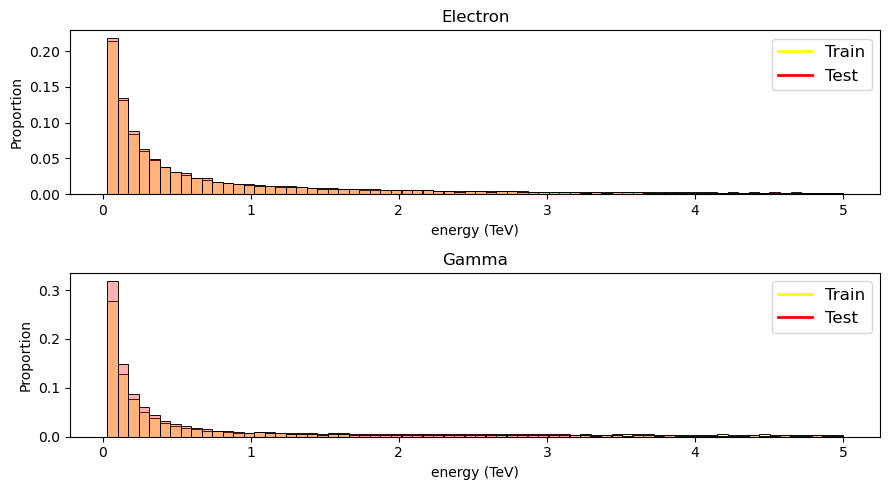

In [66]:
# Un poco de info sobre las PDF de la energía (TeV) en estos eventos
plt.figure(figsize=(9,5))

ax = plt.subplot(2, 1, 1)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in train_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]], x="energy (TeV)", ax=ax, stat="proportion",color="yellow", alpha=0.3, bins=70)


ax = plt.subplot(2, 1, 2)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="gamma")].loc[[True if i in train_runs_list[0] else False for i in df_common_events.loc[df_common_events["elemento"]=="gamma","run"]]], x="energy (TeV)", ax=ax, stat="proportion",color="yellow", alpha=0.3, bins=70)


plt.subplot(2, 1, 1)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="electron")].loc[[True if i in test_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]]], x="energy (TeV)", stat="proportion",color="red", alpha=0.3, bins=70)
custom_legend_3 = [Line2D([0], [0], color='yellow', lw=2),Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_legend_3, ['Train','Test'],fontsize=12)
plt.title("Electron",fontsize=12)

plt.subplot(2, 1, 2)
sns.histplot(df_common_events.loc[(df_common_events["elemento"]=="gamma")].loc[[True if i in test_runs_list[0] else False for i in df_common_events.loc[df_common_events["elemento"]=="gamma","run"]]], x="energy (TeV)", stat="proportion",color="red", alpha=0.3, bins=70)
custom_legend_4 = [Line2D([0], [0], color='yellow', lw=2),Line2D([0], [0], color='red', lw=2)]
plt.legend(custom_legend_4, ['Train','Test'],fontsize=12)
plt.title("Gamma",fontsize=12)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/013_pdf_energias_traintest_2_horizontal.png")

In [ ]:
sum([True if i in train_runs_list[1] else False for i in df_common_events.loc[df_common_events["elemento"]=="electron","run"]])

69096

In [ ]:
train_runs_list[0]

[64,
 49,
 48,
 35,
 50,
 51,
 9,
 100,
 31,
 70,
 98,
 15,
 76,
 93,
 72,
 69,
 30,
 58,
 41,
 46,
 63,
 22,
 39,
 57,
 91,
 18,
 79,
 59,
 52,
 45,
 99,
 17,
 81,
 21,
 27,
 89,
 42,
 68,
 13,
 26,
 73,
 84,
 94,
 16,
 85,
 95,
 55,
 36,
 25,
 29,
 32,
 44,
 33,
 47,
 71,
 97,
 82,
 65,
 43,
 90,
 5,
 86,
 78,
 75,
 10,
 74,
 56,
 77,
 12,
 1,
 92,
 61,
 8,
 14,
 11]

In [14]:
test_runs=df_lista_runs.loc[df_lista_runs["mode"]=="Test"].set_index("elemento")
test_runs=test_runs.loc[elementos].reset_index()
test_runs_list=list(test_runs["list_runs"].to_numpy())
test_runs_list

[[6, 24, 62, 40, 4, 34, 20, 88, 60, 67, 38, 19, 96, 37, 83, 87, 7, 66, 80, 23],
 [215,
  137,
  187,
  151,
  194,
  40,
  341,
  313,
  356,
  33,
  5,
  70,
  112,
  339,
  295,
  329,
  172,
  253,
  196,
  68,
  150,
  24,
  147,
  272,
  318,
  46,
  86,
  281,
  167,
  359,
  80,
  59,
  335,
  249,
  316,
  204,
  53,
  73,
  174,
  32,
  214,
  286,
  113,
  247,
  216,
  129,
  107,
  21,
  60,
  66,
  173,
  199,
  84,
  27,
  51,
  213,
  156,
  268,
  201,
  348,
  181,
  306,
  259,
  367,
  23,
  220,
  31,
  265,
  308,
  20]]

In [15]:
with open(f"{RESULTS_DIR}/hist_2_300.pickle","rb") as pick:
    hist= pickle.load(pick)

In [16]:
hist.keys()

dict_keys(['loss', 'mae', 'mape', 'val_loss', 'val_mae', 'val_mape'])

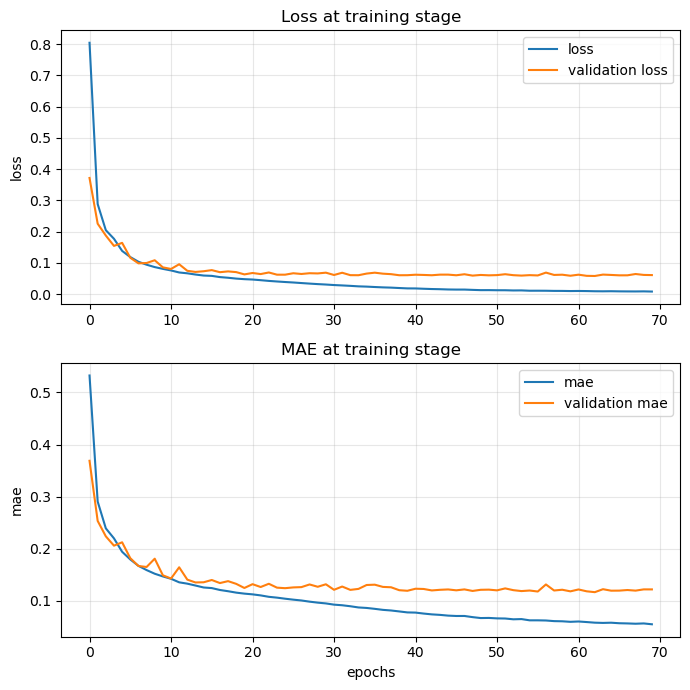

In [67]:
fig = plt.figure(figsize=(7,7))
ax=plt.subplot(2,1,1)
plt.plot(hist["loss"],label="loss")
plt.plot(hist["val_loss"],label="validation loss")
plt.legend()
plt.ylabel("loss")
plt.title("Loss at training stage")
plt.grid(alpha=0.3)
plt.subplot(2,1,2,sharex=ax)
plt.plot(hist["mae"],label="mae")
plt.plot(hist["val_mae"],label="validation mae")
plt.ylabel("mae")
plt.title("MAE at training stage")
plt.xlabel("epochs")

plt.legend()
plt.grid(alpha=0.3)

plt.tight_layout()
plt.savefig(f"{RESULTS_DIR}/013_loss_2.png")

In [18]:
modelo=tf.keras.models.load_model(f"{RESULTS_DIR}/test_2_300.h5")

2023-07-09 19:19:19.263343: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 9648 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1a:00.0, compute capability: 7.5
2023-07-09 19:19:19.265128: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 9648 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1b:00.0, compute capability: 7.5
2023-07-09 19:19:19.266784: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 9648 MB memory:  -> device: 2, name: NVIDIA GeForce RTX 2080 Ti, pci bus id: 0000:1c:00.0, compute capability: 7.5
2023-07-09 19:19:19.268002: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 9648 MB memory:  -> device: 3, name: NVIDIA GeForce RTX

In [19]:
runs_aux1=df_lista_runs.loc[df_lista_runs["mode"]=="Test",["elemento","list_runs"]]
#runs_aux1["list_runs"]=runs_aux1["list_runs"].apply(lambda x : ast.literal_eval(x))
runs_aux1

,elemento,list_runs
0,electron,"[215, 137, 187, 151, 194, 40, 341, 313, 356, 3..."
2,gamma,"[6, 24, 62, 40, 4, 34, 20, 88, 60, 67, 38, 19,..."


In [20]:
def cambiar_ejes_lista(lista):
    for i,j in enumerate(lista):
        lista[i]=np.swapaxes(j,1,2)
    return lista

In [21]:
mapping_labels={ j : i if i<=2 else 2 for i,j in enumerate(elementos)}
labels_mapped=[mapping_labels[i] for i in list(runs_aux1.elemento) ]
labels_mapped

[1, 0]

In [22]:
list(runs_aux1.list_runs)

[[215,
  137,
  187,
  151,
  194,
  40,
  341,
  313,
  356,
  33,
  5,
  70,
  112,
  339,
  295,
  329,
  172,
  253,
  196,
  68,
  150,
  24,
  147,
  272,
  318,
  46,
  86,
  281,
  167,
  359,
  80,
  59,
  335,
  249,
  316,
  204,
  53,
  73,
  174,
  32,
  214,
  286,
  113,
  247,
  216,
  129,
  107,
  21,
  60,
  66,
  173,
  199,
  84,
  27,
  51,
  213,
  156,
  268,
  201,
  348,
  181,
  306,
  259,
  367,
  23,
  220,
  31,
  265,
  308,
  20],
 [6, 24, 62, 40, 4, 34, 20, 88, 60, 67, 38, 19, 96, 37, 83, 87, 7, 66, 80, 23]]

In [23]:
aux_list=[i[-70:] for i in list(runs_aux1.list_runs)]
aux_list

[[215,
  137,
  187,
  151,
  194,
  40,
  341,
  313,
  356,
  33,
  5,
  70,
  112,
  339,
  295,
  329,
  172,
  253,
  196,
  68,
  150,
  24,
  147,
  272,
  318,
  46,
  86,
  281,
  167,
  359,
  80,
  59,
  335,
  249,
  316,
  204,
  53,
  73,
  174,
  32,
  214,
  286,
  113,
  247,
  216,
  129,
  107,
  21,
  60,
  66,
  173,
  199,
  84,
  27,
  51,
  213,
  156,
  268,
  201,
  348,
  181,
  306,
  259,
  367,
  23,
  220,
  31,
  265,
  308,
  20],
 [6, 24, 62, 40, 4, 34, 20, 88, 60, 67, 38, 19, 96, 37, 83, 87, 7, 66, 80, 23]]

In [24]:
PATH_NPY=f"{BASE_DIR}/data_full/elementos_npy"
x_train_list,x_test_list,y_train_list,y_test_list,element_shapes=loaddata4use.load_dataset_energy(PATH_NPY,PATH_TXT,elementos=list(runs_aux1.elemento),
                                                        main_list_runs=aux_list,telescopios=[1,2,3,4],test_size=0,return_shapes=True,
                                                        same_quant="all",verbose=True,fill=True,lower_energy_bound=0,
                                                        upper_energy_bound=7)
x_train_list=cambiar_ejes_lista(x_train_list)

Load of names and common events
_______________
Runs:  [215, 137, 187, 151, 194, 40, 341, 313, 356, 33, 5, 70, 112, 339, 295, 329, 172, 253, 196, 68, 150, 24, 147, 272, 318, 46, 86, 281, 167, 359, 80, 59, 335, 249, 316, 204, 53, 73, 174, 32, 214, 286, 113, 247, 216, 129, 107, 21, 60, 66, 173, 199, 84, 27, 51, 213, 156, 268, 201, 348, 181, 306, 259, 367, 23, 220, 31, 265, 308, 20]
Element:  electron  , Run:  215  Shape of common events (common events, energies):  (4, 238) (4, 238)
Element:  electron  , Run:  137  Shape of common events (common events, energies):  (4, 237) (4, 237)
Element:  electron  , Run:  187  Shape of common events (common events, energies):  (4, 246) (4, 246)
Element:  electron  , Run:  151  Shape of common events (common events, energies):  (4, 258) (4, 258)
Element:  electron  , Run:  194  Shape of common events (common events, energies):  (4, 268) (4, 268)
Element:  electron  , Run:  40  Shape of common events (common events, energies):  (4, 226) (4, 226)
Elemen

Element:  electron  , Run:  329  Shape of common events (common events, energies):  (4, 249) (4, 249)
Element:  electron  , Run:  172  Shape of common events (common events, energies):  (4, 254) (4, 254)
Element:  electron  , Run:  253  Shape of common events (common events, energies):  (4, 259) (4, 259)
Element:  electron  , Run:  196  Shape of common events (common events, energies):  (4, 236) (4, 236)
Element:  electron  , Run:  68  Shape of common events (common events, energies):  (4, 246) (4, 246)
Element:  electron  , Run:  150  Shape of common events (common events, energies):  (4, 268) (4, 268)
Element:  electron  , Run:  24  Shape of common events (common events, energies):  (4, 232) (4, 232)
Element:  electron  , Run:  147  Shape of common events (common events, energies):  (4, 238) (4, 238)
Element:  electron  , Run:  272  Shape of common events (common events, energies):  (4, 245) (4, 245)
Element:  electron  , Run:  318  Shape of common events (common events, energies):  

In [25]:
modelo=tf.keras.models.load_model(f"{RESULTS_DIR}/test_2_300.h5")

In [26]:
y_pred_all=[]
total_len=x_train_list[1].shape[0]
n=350
cicles=int(np.ceil(total_len/n))
for i in range(cicles):
    print("Ciclo",i)
    if (n*i+n)>=total_len:
        final=total_len
    else:
        final=n*i+n

    x_aux=[ x[(n*i):final,:,:,:] for x in x_train_list]
    print("Shape",x_aux[0].shape)
    y_pred=modelo(x_aux).numpy()
    if i==0:
        y_pred_all=y_pred
    else:
        # for j in range(len(y_pred_all)):
        y_pred_all=np.concatenate([y_pred_all,y_pred],axis=0)


Ciclo 0
Shape (350, 55, 93, 1)


2023-07-09 19:44:02.434530: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8800


Ciclo 1
Shape (350, 55, 93, 1)
Ciclo 2
Shape (350, 55, 93, 1)
Ciclo 3
Shape (350, 55, 93, 1)
Ciclo 4
Shape (350, 55, 93, 1)
Ciclo 5
Shape (350, 55, 93, 1)
Ciclo 6
Shape (350, 55, 93, 1)
Ciclo 7
Shape (350, 55, 93, 1)
Ciclo 8
Shape (350, 55, 93, 1)
Ciclo 9
Shape (350, 55, 93, 1)
Ciclo 10
Shape (350, 55, 93, 1)
Ciclo 11
Shape (350, 55, 93, 1)
Ciclo 12
Shape (350, 55, 93, 1)
Ciclo 13
Shape (350, 55, 93, 1)
Ciclo 14
Shape (350, 55, 93, 1)
Ciclo 15
Shape (350, 55, 93, 1)
Ciclo 16
Shape (350, 55, 93, 1)
Ciclo 17
Shape (350, 55, 93, 1)
Ciclo 18
Shape (350, 55, 93, 1)
Ciclo 19
Shape (350, 55, 93, 1)
Ciclo 20
Shape (350, 55, 93, 1)
Ciclo 21
Shape (350, 55, 93, 1)
Ciclo 22
Shape (350, 55, 93, 1)
Ciclo 23
Shape (350, 55, 93, 1)
Ciclo 24
Shape (350, 55, 93, 1)
Ciclo 25
Shape (350, 55, 93, 1)
Ciclo 26
Shape (350, 55, 93, 1)
Ciclo 27
Shape (350, 55, 93, 1)
Ciclo 28
Shape (350, 55, 93, 1)
Ciclo 29
Shape (350, 55, 93, 1)
Ciclo 30
Shape (350, 55, 93, 1)
Ciclo 31
Shape (350, 55, 93, 1)
Ciclo 32
Shape (3

In [31]:
y_pred=modelo.predict(x_train_list)

1290/1290 [==============================] - 14s 11ms/step


In [40]:
#np.save(f"{RESULTS_DIR}/test-pred_energy_2_300.npy",np.stack([y_train_list,y_pred.squeeze()],axis=1))

In [41]:
# Polynomial Regression
def polyfit(x, y, degree):
    results = {}

    coeffs = np.polyfit(x, y, degree)

     # Polynomial Coefficients
    results['polynomial'] = coeffs.tolist()

    # r-squared
    p = np.poly1d(coeffs)
    # fit values, and mean
    yhat = p(x)                      # or [p(z) for z in x]
    ybar = np.sum(y)/len(y)          # or sum(y)/len(y)
    ssreg = np.sum((yhat-ybar)**2)   # or sum([ (yihat - ybar)**2 for yihat in yhat])
    sstot = np.sum((y - ybar)**2)    # or sum([ (yi - ybar)**2 for yi in y])
    results["y_pred"]=yhat
    results['determination'] = ssreg / sstot

    return results,p

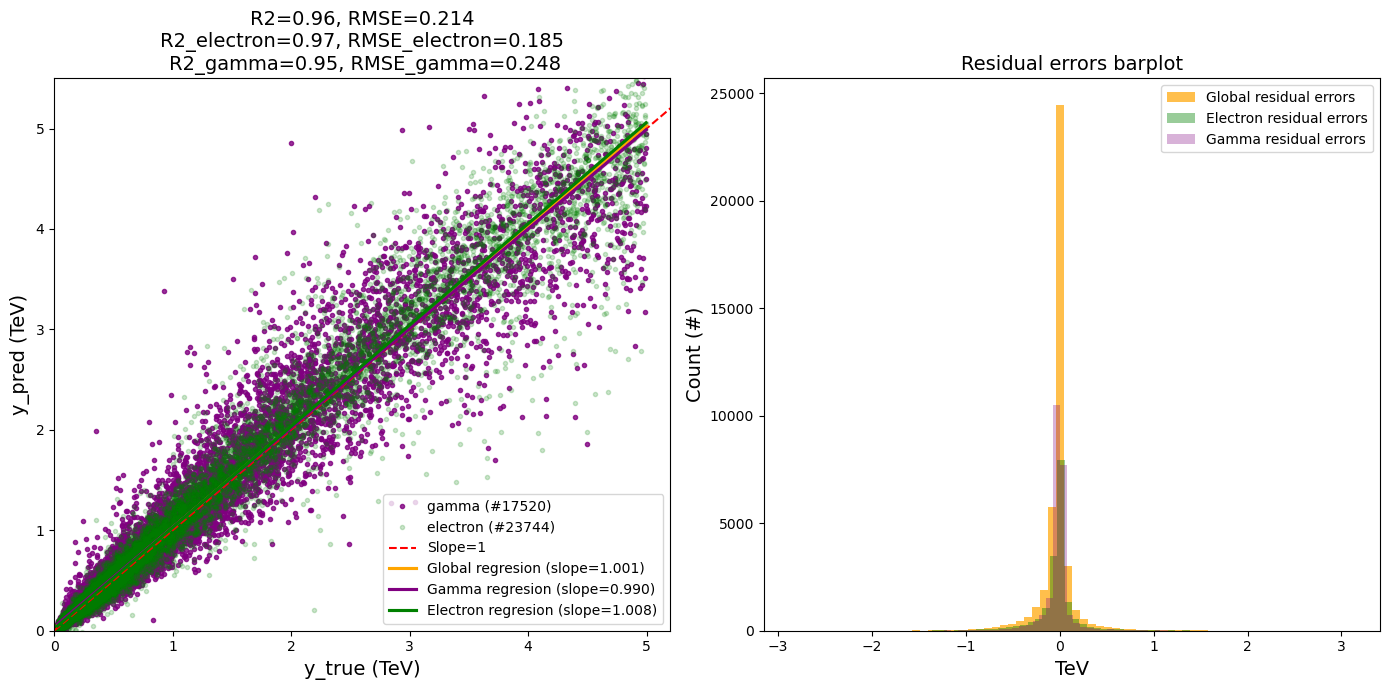

In [56]:
y_train_list_electron=y_train_list[element_shapes[0]:]
y_train_list_gamma=y_train_list[:element_shapes[0]]

y=y_pred_all.squeeze()

y_electron=y[element_shapes[0]:]
y_gamma=y[:element_shapes[0]]

x_aux=np.linspace(-0.1,5.2,50)

results,model_poly=polyfit(y_train_list,y,1)
results_electron,model_poly_electron=polyfit(y_train_list_electron,y_electron,1)
results_gamma,model_poly_gamma=polyfit(y_train_list_gamma,y_gamma,1)

rmse=np.sqrt(np.mean((y-y_train_list)**2))
rmse_gamma=np.sqrt(np.mean((y_gamma-y_train_list_gamma)**2))
rmse_electron=np.sqrt(np.mean((y_electron-y_train_list_electron)**2))

#y_poly_fit=model_poly(x_aux)
fig=plt.figure(figsize=(14,7))
ax=plt.subplot(1,2,1)
plt.plot(y_train_list_gamma,y_gamma,".",color="purple",label=f"gamma (#{element_shapes[0]})",alpha=0.8)
plt.plot(y_train_list_electron,y_electron,".",color="green",label=f"electron (#{element_shapes[1]})",alpha=0.2)

plt.plot(np.arange(7),"--r",label="Slope=1")
sns.regplot(data=pd.DataFrame({"X":y_train_list,"Y":y}),x="X",y="Y",ax=ax,line_kws={'color': 'orange'},label=f"Global regresion (slope={results['polynomial'][0]:.3f})",scatter=False)
sns.regplot(data=pd.DataFrame({"X":y_train_list_gamma,"Y":y_gamma}),x="X",y="Y",ax=ax,line_kws={'color': 'purple'},label=f"Gamma regresion (slope={results_gamma['polynomial'][0]:.3f})",scatter=False)
sns.regplot(data=pd.DataFrame({"X":y_train_list_electron,"Y":y_electron}),x="X",y="Y",ax=ax,line_kws={'color': 'green'},label=f"Electron regresion (slope={results_electron['polynomial'][0]:.3f})",scatter=False)

plt.xlim(0,5.2)
plt.ylim(0,5.5)
plt.xlabel("y_true (TeV)",fontsize=14)
plt.ylabel("y_pred (TeV)",fontsize=14)
plt.legend()
plt.title(f" R2={results['determination']:.2f}, RMSE={rmse:.3f} \n R2_electron={results_electron['determination']:.2f}, RMSE_electron={rmse_electron:.3f} \n R2_gamma={results_gamma['determination']:.2f}, RMSE_gamma={rmse_gamma:.3f}",fontsize=14)
#plt.savefig(f"./results_UGR/energias/013_correlation_energy_2.png")
#plt.clf()
#plt.close(fig)
#plot de la distribucion de errores
ax=plt.subplot(1,2,2)
res=y_train_list-y
res_gamma=y_train_list_electron-y_electron
res_electron=y_train_list_gamma-y_gamma
plt.hist(res,bins=70,label="Global residual errors",density=False,color="orange",alpha=0.7)
plt.hist(res_electron,bins=70,label="Electron residual errors",density=False,color="green",alpha=0.4)
plt.hist(res_gamma,bins=70,label="Gamma residual errors",density=False,color="purple",alpha=0.3)
#plt.yscale("log")
plt.legend()
plt.title(f"Residual errors barplot",fontsize=14)# ; std: {np.std(y_train_list-y)}")
plt.ylabel("Count (#)",fontsize=14)
plt.xlabel("TeV",fontsize=14)
plt.savefig(f"{RESULTS_DIR}/reg_and_resid_energy_NOlog_2.png")
#plt.clf()
#plt.close(fig2)
plt.tight_layout()

In [16]:
energias_per_run=df_common_events.groupby(["elemento","run"]).agg(list).drop(columns="eventos")
energias_per_run

energia
elemento run                                                   
electron 1    [0.1307, 0.1603, 0.8038, 0.6685, 0.2394, 0.107...
         2    [1.5473, 0.3698, 0.1355, 0.9396, 0.1923, 0.121...
         3    [0.139, 0.0418, 0.0467, 1.0707, 0.2228, 0.1403...
         4    [0.0428, 0.1456, 0.7546, 0.3661, 0.0518, 0.186...
         5    [0.104, 3.3916, 0.3936, 0.3255, 0.3975, 0.1012...
...                                                         ...
gamma    96   [3.5857, 3.3987, 4.1356, 3.7503, 4.2455, 1.835...
         97   [1.9977, 4.5194, 1.0669, 1.0817, 1.5956, 3.884...
         98   [1.558, 1.6409, 4.9117, 3.5624, 2.1339, 2.9231...
         99   [2.0581, 4.1603, 2.2546, 1.881, 2.5756, 1.9734...
         100  [2.8502, 4.095, 3.3945, 3.6528, 3.6322, 2.7622...

[441 rows x 1 columns]

In [19]:
runs_aux1=test_runs.loc[test_runs["mode"]=="Test",["elemento","list_runs"]]
runs_aux1["list_runs"]=runs_aux1["list_runs"].apply(lambda x : ast.literal_eval(x))

In [26]:
multi_indices=runs_aux1.explode("list_runs").to_numpy()
multi_indices=[tuple(i) for i in multi_indices]
multi_indices

[('gamma', 6),
 ('gamma', 24),
 ('gamma', 62),
 ('gamma', 40),
 ('gamma', 4),
 ('gamma', 34),
 ('gamma', 20),
 ('gamma', 88),
 ('gamma', 60),
 ('gamma', 67),
 ('gamma', 38),
 ('gamma', 19),
 ('gamma', 96),
 ('gamma', 37),
 ('gamma', 83),
 ('gamma', 87),
 ('gamma', 7),
 ('gamma', 66),
 ('gamma', 80),
 ('gamma', 23),
 ('electron', 215),
 ('electron', 137),
 ('electron', 187),
 ('electron', 151),
 ('electron', 194),
 ('electron', 40),
 ('electron', 341),
 ('electron', 313),
 ('electron', 356),
 ('electron', 33),
 ('electron', 5),
 ('electron', 70),
 ('electron', 112),
 ('electron', 339),
 ('electron', 295),
 ('electron', 329),
 ('electron', 172),
 ('electron', 253),
 ('electron', 196),
 ('electron', 68),
 ('electron', 150),
 ('electron', 24),
 ('electron', 147),
 ('electron', 272),
 ('electron', 318),
 ('electron', 46),
 ('electron', 86),
 ('electron', 281),
 ('electron', 167),
 ('electron', 359),
 ('electron', 80),
 ('electron', 59),
 ('electron', 335),
 ('electron', 249),
 ('electron', 

In [21]:
runs_aux1["list_runs"]=[i[-300:] for i in runs_aux1["list_runs"]]
runs_aux1

,elemento,list_runs
0,gamma,"[6, 24, 62, 40, 4, 34, 20, 88, 60, 67, 38, 19,..."
1,electron,"[215, 137, 187, 151, 194, 40, 341, 313, 356, 3..."


In [27]:
energias_train=energias_per_run.loc[multi_indices]
energias_train=energias_train.groupby("elemento")["energia"].agg(np.concatenate)
energias_train

elemento
electron    [0.1405, 0.2912, 0.4774, 0.1852, 0.1417, 3.678...
gamma       [0.3707, 0.0977, 0.1061, 0.2043, 0.0512, 0.042...
Name: energia, dtype: object

In [28]:
energias_train.apply(len)

elemento
electron    17520
gamma       23744
Name: energia, dtype: int64

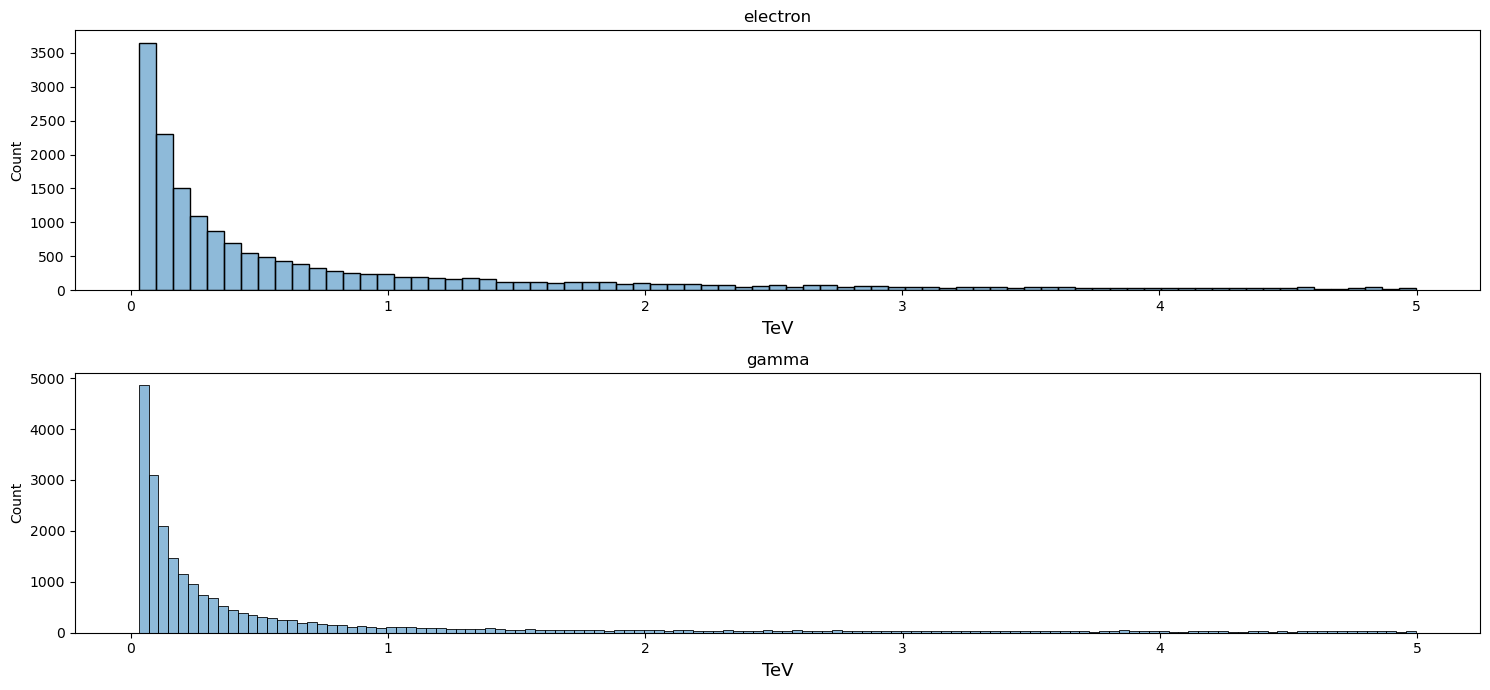

In [29]:
plt.figure(figsize=(15,7))

for k,(i,j) in enumerate(energias_train.items()):
    plt.subplot(2,1,k+1)
    sns.histplot({i:j},legend=False)
    plt.title(i)
    plt.xlabel("TeV",fontsize=13)
    
plt.tight_layout()